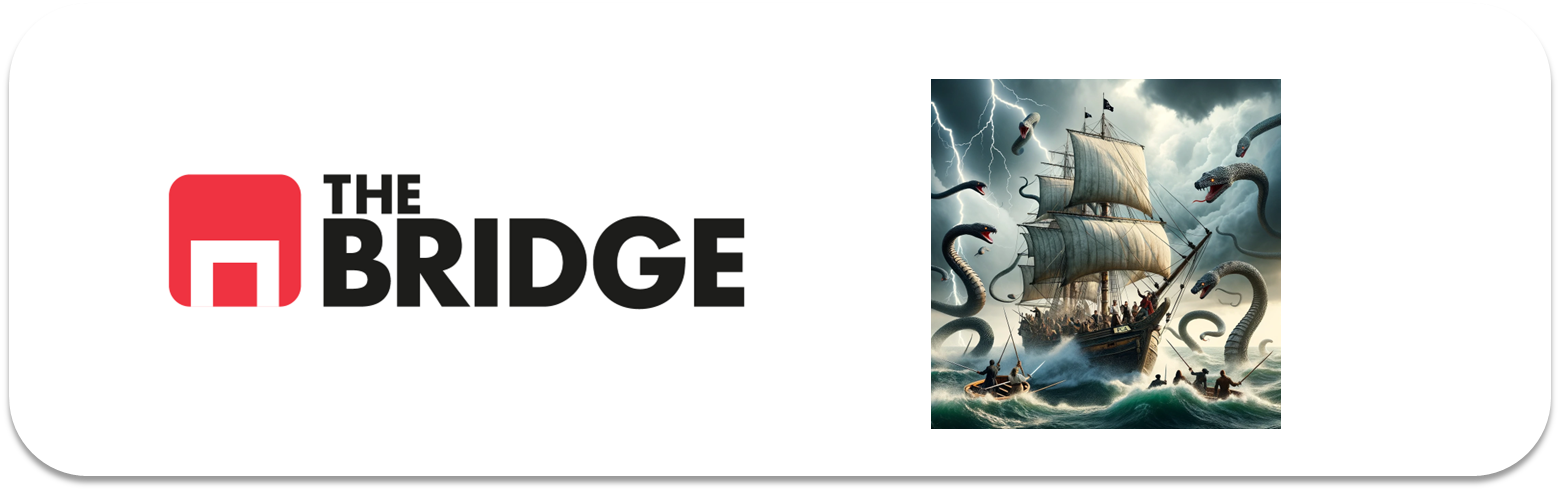

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import (
    VarianceThreshold, SelectKBest, f_classif,
    SelectFromModel, RFE
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

from sklearn.feature_selection import SequentialFeatureSelector

import bootcampviztools as bvt

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


## Carga del dataset y target

In [2]:
df = pd.read_csv("data/credit_npo.csv", sep=",")

target = "SeriousDlqin2yrs"
# Drop de nulos
df = df.dropna().copy()

print(df.shape)
df.head(3)


(11816, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0


## Conversión de 'NumberOf...' a categóricas

In [3]:
numberof_cols = [c for c in df.columns if c.startswith("NumberOf") and c != target]

for c in numberof_cols:
    if df[c].nunique() <= 10:
        df[c] = pd.cut(df[c], bins=[-np.inf, 0, 1, np.inf], labels=["0", "1", "2+"]).astype("category")

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target]
num_cols = [c for c in df.columns if c not in cat_cols + [target]]

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)


Categóricas: ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
Numéricas: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines']


## EDA

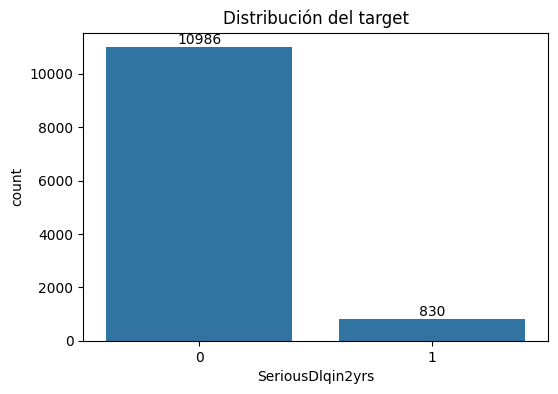

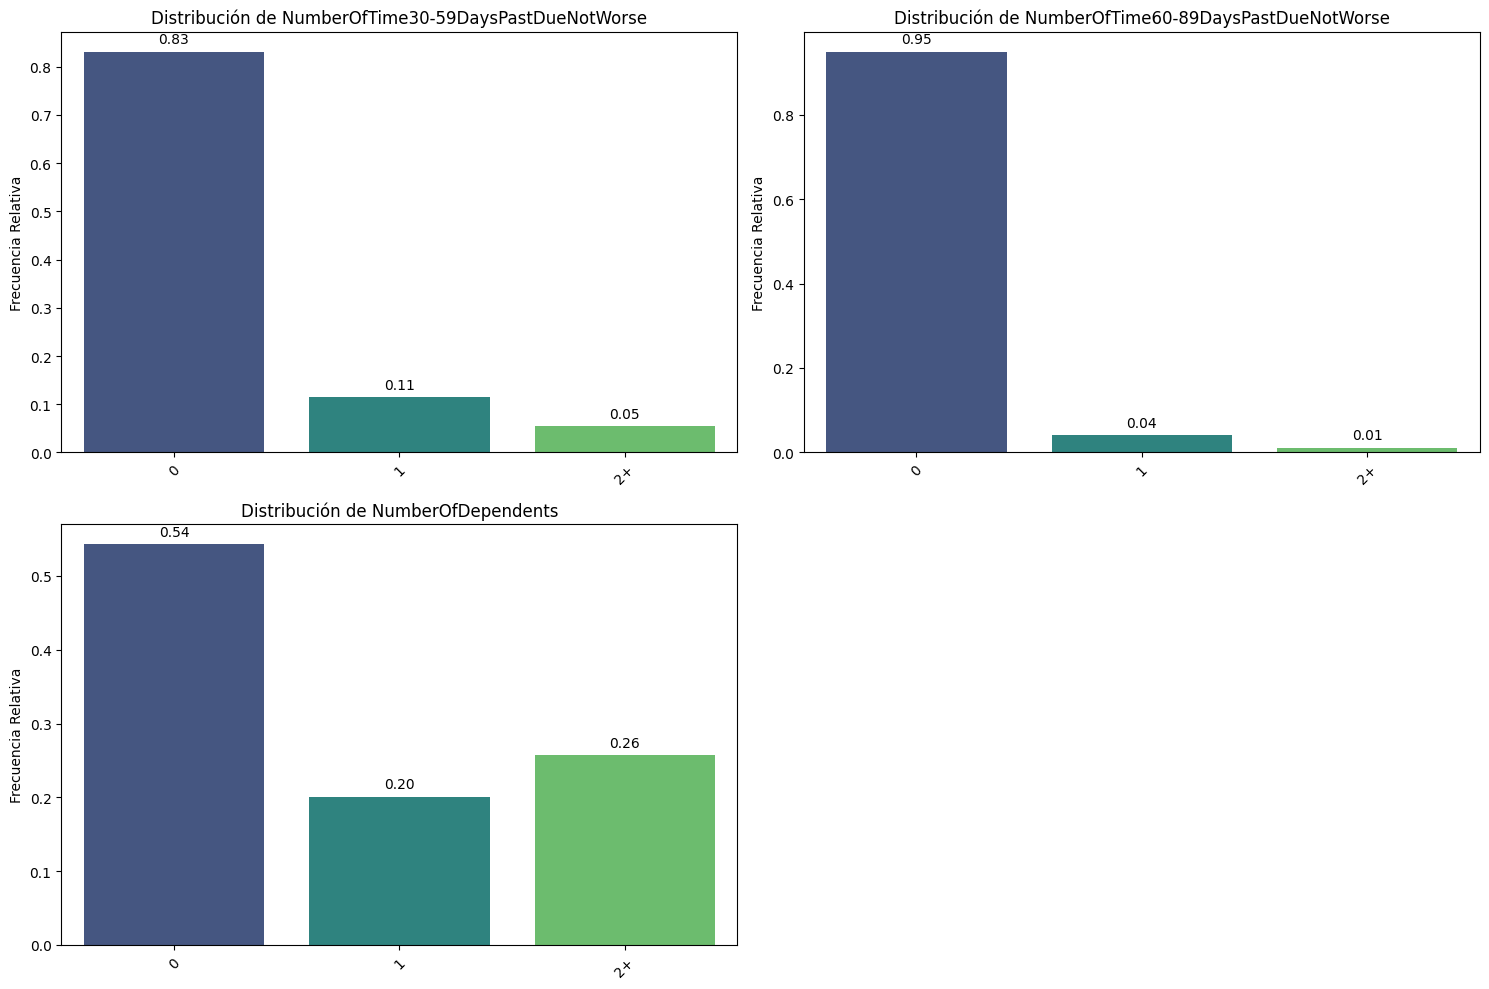

/Users/jorge/bridge/code/ONLINE_DS_THEBRIDGE_jorgegp/Sprint_14/Unidad_02_ML_No_Supervisado_Feature_Selection/03_Practica_Obligatoria/bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


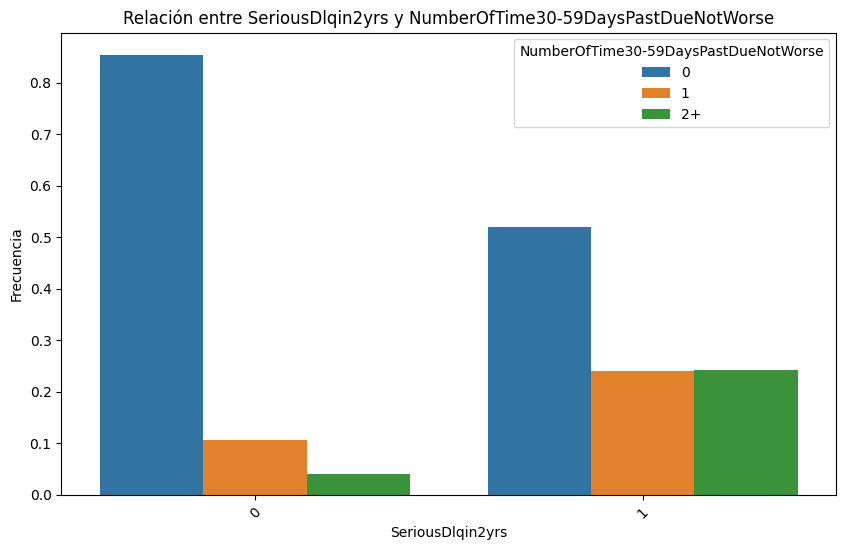

/Users/jorge/bridge/code/ONLINE_DS_THEBRIDGE_jorgegp/Sprint_14/Unidad_02_ML_No_Supervisado_Feature_Selection/03_Practica_Obligatoria/bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


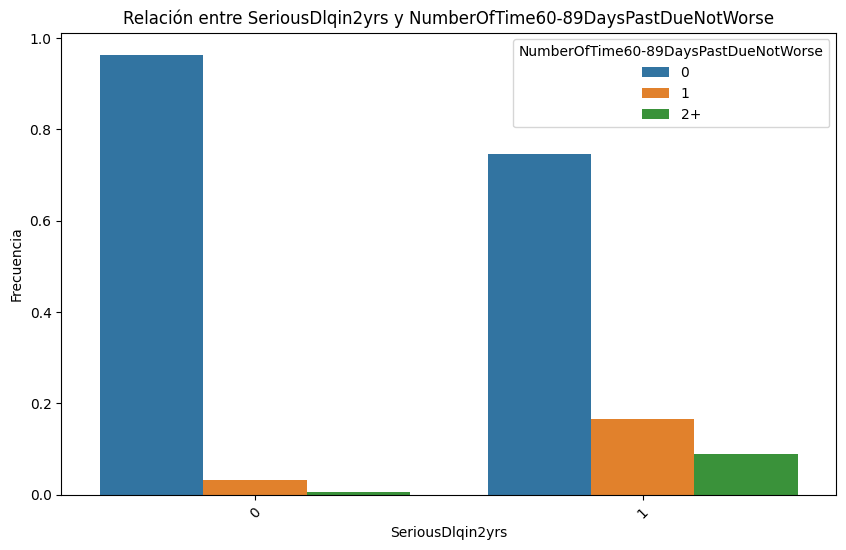

/Users/jorge/bridge/code/ONLINE_DS_THEBRIDGE_jorgegp/Sprint_14/Unidad_02_ML_No_Supervisado_Feature_Selection/03_Practica_Obligatoria/bootcampviztools.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')


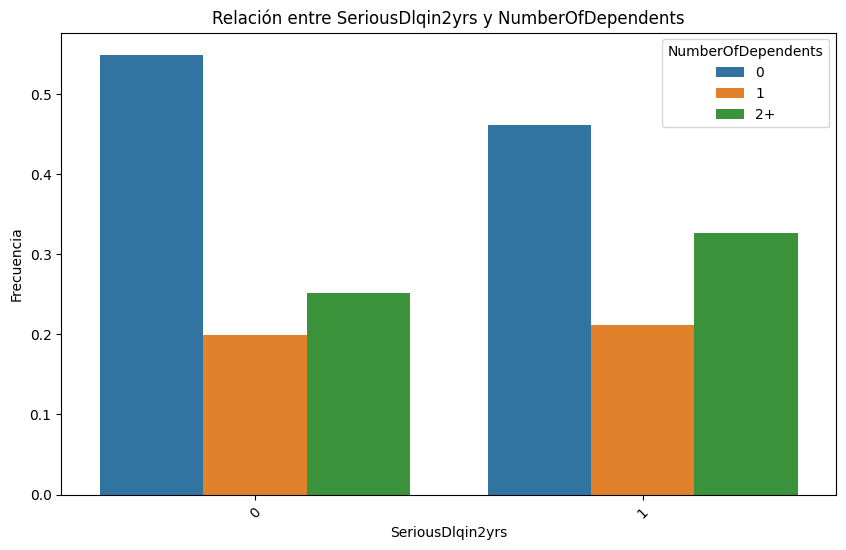

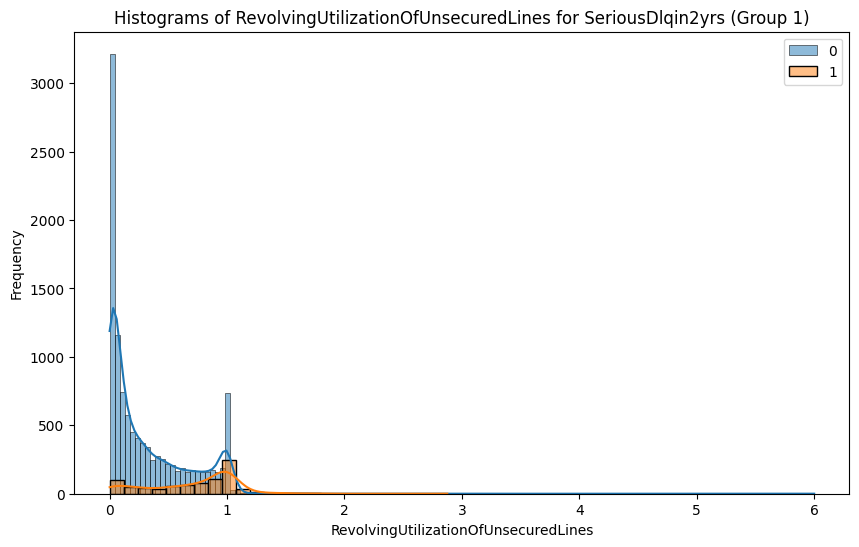

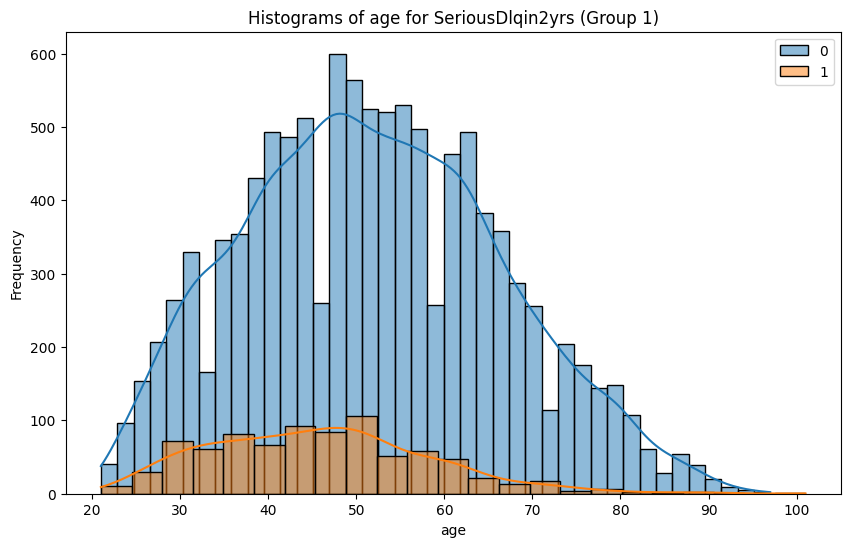

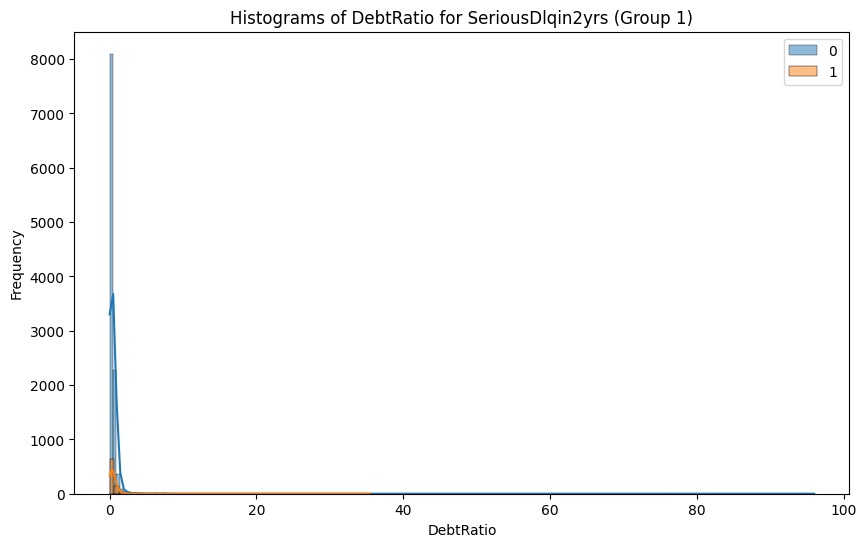

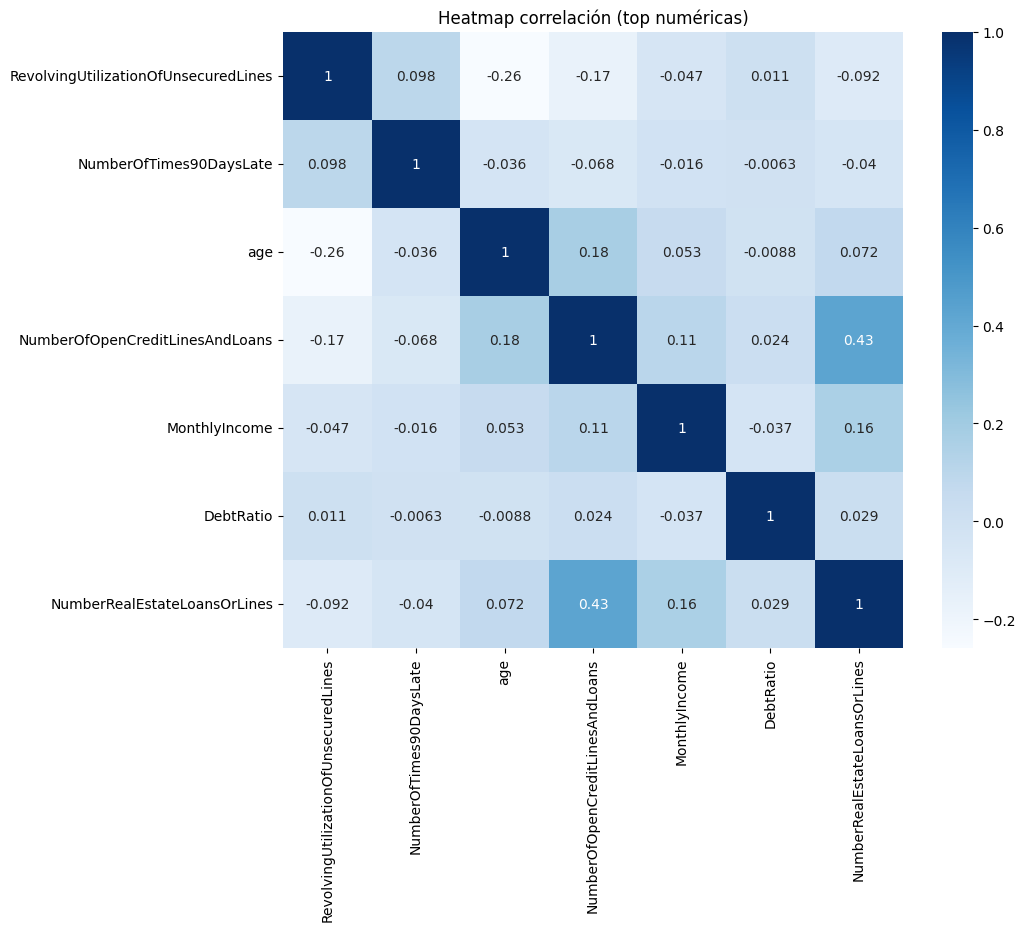

['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTimes90DaysLate', 'age', 'NumberOfOpenCreditLinesAndLoans', 'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines']


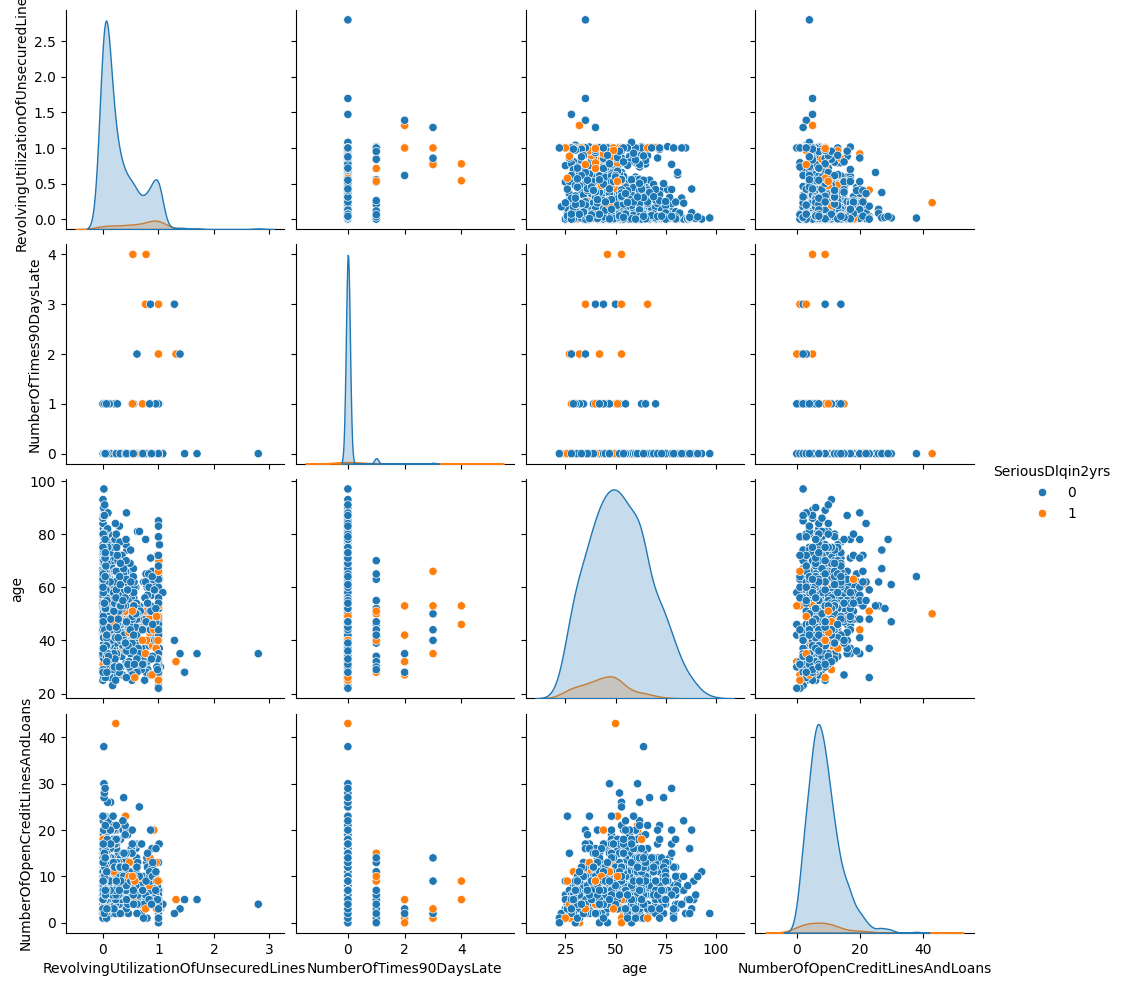

In [4]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x=target, data=df)
ax.set_title("Distribución del target")
ax.bar_label(ax.containers[0])
plt.show()

bvt.pinta_distribucion_categoricas(df, cat_cols[:6], relativa=True, mostrar_valores=True)

for c in cat_cols[:4]:
    bvt.plot_categorical_relationship_fin(df, target, c, relative_freq=True, show_values=False, size_group=5)

for c in num_cols[:3]:
    bvt.plot_grouped_histograms(df, cat_col=target, num_col=c, group_size=2)

corr = df[num_cols + [target]].corr(numeric_only=True)

top_num = corr[target].abs().sort_values(ascending=False).index.tolist()
top_num = [c for c in top_num if c != target][:8]

plt.figure(figsize=(10,8))
sns.heatmap(corr.loc[top_num, top_num], annot=True, cmap="Blues")
plt.title("Heatmap correlación (top numéricas)")
plt.show()

print(top_num)

pair_cols = top_num[:4]
sns.pairplot(df[pair_cols + [target]].sample(min(800, len(df)), random_state=42), hue=target)

plt.show()

## Split Train/Test

In [5]:
X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (9452, 10) Test: (2364, 10)


## Preprocesado
- Numéricas: `StandardScaler`
- Categóricas: `OrdinalEncoder`

In [6]:

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


## 6 listas de features (máximo 6 features)

In [7]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out().tolist()
feature_names[:10], len(feature_names)


(['RevolvingUtilizationOfUnsecuredLines',
  'age',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'],
 10)

In [ ]:
# Funciones a utilizar despues
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)

def names_from_support(support):
    return [f for f, keep in zip(feature_names, support) if keep]

def cap6(lst):
    return lst[:6] if len(lst) > 6 else lst

In [22]:
Xtr_df = pd.DataFrame(Xtr, columns=feature_names)
corrs = Xtr_df.apply(lambda col: np.corrcoef(col, y_train)[0,1])
corrs = corrs.abs().sort_values(ascending=False)

num_feats = [f for f in corrs.index if f in num_cols]
list_1 = num_feats[:5]


mi = mutual_info_classif(Xtr, y_train, random_state=42)
mi_s = pd.Series(mi, index=feature_names).sort_values(ascending=False)
best_cat = [f for f in mi_s.index if f in cat_cols]
list_1 = list_1 + [best_cat[0]]

list_1 = cap6(list(dict.fromkeys(list_1)))
list_1

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTimes90DaysLate',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'MonthlyIncome',
 'NumberOfTime30-59DaysPastDueNotWorse']

In [ ]:
# ANOVA
skb_f = SelectKBest(score_func=f_classif, k=min(6, Xtr.shape[1]))
skb_f.fit(Xtr, y_train)
list_2 = names_from_support(skb_f.get_support())
list_2 = cap6(list_2)
list_2

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [ ]:

# SelectKBest con Mutual Information
skb_mi = SelectKBest(score_func=mutual_info_classif, k=min(6, Xtr.shape[1]))
skb_mi.fit(Xtr, y_train)
list_3 = names_from_support(skb_mi.get_support())
list_3 = cap6(list_3)
list_3

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
# LogisticRegression L1
l1 = LogisticRegression(l1_ratio=0, solver="liblinear", class_weight="balanced", max_iter=2000, random_state=42)
sfm = SelectFromModel(l1, max_features=6)
sfm.fit(Xtr, y_train)
list_4 = names_from_support(sfm.get_support())
list_4 = cap6(list_4)
list_4

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTimes90DaysLate',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
# LogisticRegression
base_lr = LogisticRegression(l1_ratio=0, solver="liblinear", class_weight="balanced", max_iter=2000, random_state=42)
rfe = RFE(estimator=base_lr, n_features_to_select=6)
rfe.fit(Xtr, y_train)
list_5 = names_from_support(rfe.get_support())
list_5 = cap6(list_5)
list_5

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
# SequentialFeatureSelector con forward
sfs = SequentialFeatureSelector(
    estimator=base_lr,
    n_features_to_select=6,
    direction="forward",
    scoring="recall",
    cv=3,
    n_jobs=-1
)
sfs.fit(Xtr, y_train)
list_6 = names_from_support(sfs.get_support())
list_6 = cap6(list_6)
list_6

['RevolvingUtilizationOfUnsecuredLines',
 'DebtRatio',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
# Hard-voting (de 1..6): me quedo con las features que aparecen al menos en 3 listas
lists = [list_1, list_2, list_3, list_4, list_5, list_6]
from collections import Counter
counts = Counter([f for lst in lists for f in lst])
hard_vote = [f for f, c in counts.most_common() if c >= 3]
hard_vote = cap6(hard_vote)
hard_vote, counts.most_common(12)

(['RevolvingUtilizationOfUnsecuredLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'age',
  'NumberOfOpenCreditLinesAndLoans'],
 [('RevolvingUtilizationOfUnsecuredLines', 6),
  ('NumberOfTime30-59DaysPastDueNotWorse', 6),
  ('NumberOfTimes90DaysLate', 5),
  ('NumberOfTime60-89DaysPastDueNotWorse', 5),
  ('age', 4),
  ('NumberOfOpenCreditLinesAndLoans', 3),
  ('NumberRealEstateLoansOrLines', 2),
  ('MonthlyIncome', 1),
  ('NumberOfDependents', 1),
  ('DebtRatio', 1)])

## Comparativa de 3 modelos y 6 listas

In [ ]:
models = {
    "LogReg": LogisticRegression(class_weight="balanced", max_iter=3000, solver="liblinear", random_state=42),
    "RF": RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced_subsample", n_jobs=-1),
    "HGB": HistGradientBoostingClassifier(random_state=42)
}

feature_sets = {
    "L1_visual_corr": list_1,
    "L2_kbest_anova": list_2,
    "L3_kbest_mi": list_3,
    "L4_sfm_l1": list_4,
    "L5_rfe": list_5,
    "L6_sfs": list_6,
    "HardVote": hard_vote
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def select_columns_after_prep(X_array, selected_features):
    idx = [feature_names.index(f) for f in selected_features]
    return X_array[:, idx]

results = []
for fs_name, feats in feature_sets.items():
    X_sel = select_columns_after_prep(Xtr, feats)
    for m_name, model in models.items():
        scores = cross_val_score(model, X_sel, y_train, scoring="recall", cv=skf, n_jobs=-1)
        results.append({
            "FeatureSet": fs_name,
            "Model": m_name,
            "Recall_mean": scores.mean(),
            "Recall_std": scores.std()
        })

res_df = pd.DataFrame(results).sort_values(["Recall_mean"], ascending=False)
res_df.head(10)


,FeatureSet,Model,Recall_mean,Recall_std
18,HardVote,LogReg,0.753087,0.029343
6,L3_kbest_mi,LogReg,0.753087,0.029343
15,L6_sfs,LogReg,0.751504,0.010660
0,L1_visual_corr,LogReg,0.748587,0.037751
12,L5_rfe,LogReg,0.734974,0.019977
9,L4_sfm_l1,LogReg,0.731966,0.013239
3,L2_kbest_anova,LogReg,0.718410,0.016980
10,L4_sfm_l1,RF,0.319310,0.019335
8,L3_kbest_mi,HGB,0.230519,0.037779
20,HardVote,HGB,0.230519,0.037779


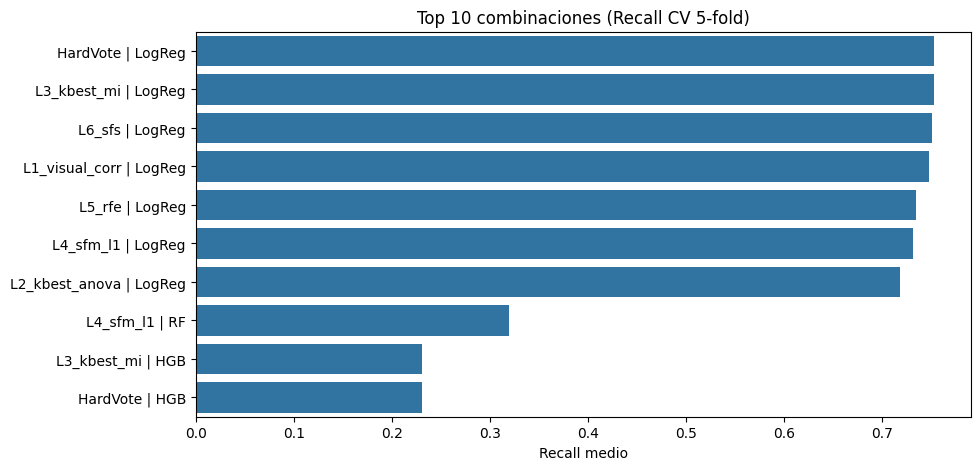

('LogReg',
 'HardVote',
 ['RevolvingUtilizationOfUnsecuredLines',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'age',
  'NumberOfOpenCreditLinesAndLoans'],
 np.float64(0.7530872636135794))

In [ ]:
# barplot de los mejores
top10 = res_df.head(10).copy()
plt.figure(figsize=(10,5))
ax = sns.barplot(data=top10, x="Recall_mean", y=top10["FeatureSet"] + " | " + top10["Model"])
ax.set_title("Top 10 combinaciones (Recall CV 5-fold)")
ax.set_xlabel("Recall medio")
ax.set_ylabel("")
plt.show()

# La mejor combinación
best_row = res_df.iloc[0]
best_fs = best_row["FeatureSet"]
best_model_name = best_row["Model"]
best_features = feature_sets[best_fs]
best_model_name, best_fs, best_features, best_row["Recall_mean"]

## Entrenamiento y evaluación en test

balanced_accuracy: 0.7636844009340364
recall: 0.7289156626506024
precision: 0.21453900709219859
roc_auc: 0.8394419351655941

Classification report:
               precision    recall  f1-score   support

           0     0.9750    0.7985    0.8779      2198
           1     0.2145    0.7289    0.3315       166

    accuracy                         0.7936      2364
   macro avg     0.5948    0.7637    0.6047      2364
weighted avg     0.9216    0.7936    0.8396      2364



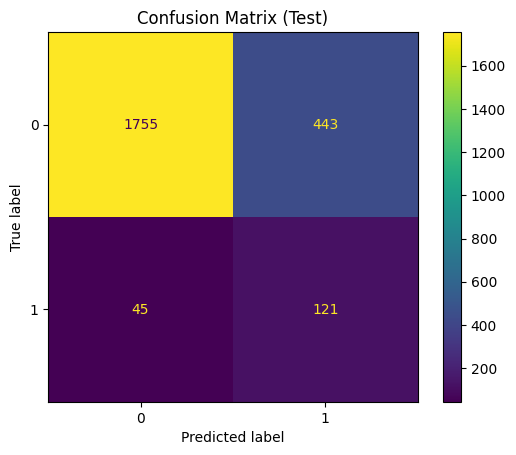

In [18]:
# Entrenamos el mejor modelo con las mejores features (ya preprocesadas)
Xtr_best = select_columns_after_prep(Xtr, best_features)
Xte_best = select_columns_after_prep(Xte, best_features)

if best_model_name == "LogReg":
    best_model = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
elif best_model_name == "RF":
    best_model = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")
elif best_model_name == "KNN":
    best_model = KNeighborsClassifier()
else:
    raise ValueError("Modelo no reconocido")

best_model.fit(Xtr_best, y_train)

y_pred = best_model.predict(Xte_best)

print("balanced_accuracy:", balanced_accuracy_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(Xte_best)[:, 1]
    print("roc_auc:", roc_auc_score(y_test, y_proba))

print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix (Test)")
plt.show()

## Optimización GridSearchCV sobre el mejor modelo

In [19]:
param_grid = {}
if best_model_name == "LogReg":
    param_grid = {"C": [0.1, 1.0, 3.0]}
elif best_model_name == "RF":
    param_grid = {"max_depth": [None, 6, 12], "min_samples_leaf": [1, 3, 5]}
elif best_model_name == "HGB":
    param_grid = {"max_depth": [None, 3, 6], "learning_rate": [0.05, 0.1], "max_iter": [200, 400]}

if best_model_name == "LogReg":
    estimator_gs = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
elif best_model_name == "RF":
    estimator_gs = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")
elif best_model_name == "KNN":
    estimator_gs = KNeighborsClassifier()
else:
    raise ValueError("Modelo no reconocido")

gs = GridSearchCV(
    estimator=estimator_gs,
    param_grid=param_grid,
    scoring="recall",
    cv=skf,
    n_jobs=-1
)

gs.fit(Xtr_best, y_train)
gs.best_params_, gs.best_score_

({'C': 0.1}, np.float64(0.7530758714969241))

=== Test con modelo ajustado ===
balanced_accuracy: 0.7618645647192956
recall: 0.7289156626506024
precision: 0.21153846153846154
roc_auc: 0.8387512744334937


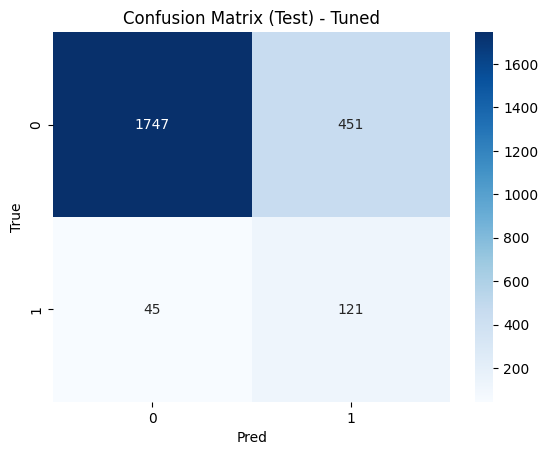

In [20]:
tuned = gs.best_estimator_
tuned.fit(Xtr_best, y_train)
y_pred_tuned = tuned.predict(Xte_best)

print("=== Test con modelo ajustado ===")
print("balanced_accuracy:", balanced_accuracy_score(y_test, y_pred_tuned))
print("recall:", recall_score(y_test, y_pred_tuned))
print("precision:", precision_score(y_test, y_pred_tuned))
if hasattr(tuned, "predict_proba"):
    y_proba_tuned = tuned.predict_proba(Xte_best)[:, 1]
    print("roc_auc:", roc_auc_score(y_test, y_proba_tuned))

cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test) - Tuned")
plt.xlabel("Pred")
plt.ylabel("True")
plt.show()

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

Numero de componentes: 8 Varianza explicada: 0.9601672256913474
balanced_accuracy: 0.7702182707170813
recall: 0.7469879518072289
precision: 0.21453287197231835
roc_auc: 0.8337289101812163


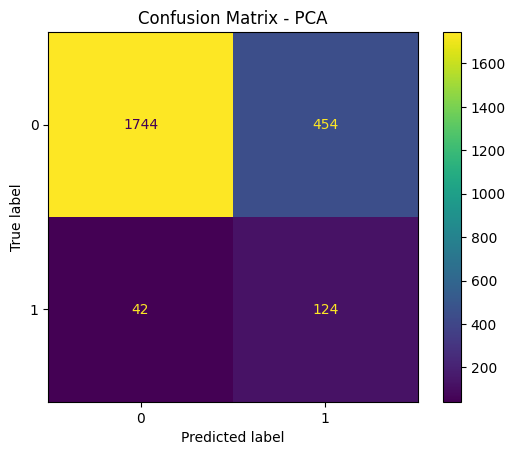

In [21]:
# Pipeline completo: preprocesado -> PCA(0.95) -> modelo del mismo tipo (best_model_name)
pca = PCA(n_components=0.95, random_state=42)

# Para PCA usamos TODAS las features preprocesadas (no seleccionadas manualmente)
Xtr_all = Xtr
Xte_all = Xte

Xtr_pca = pca.fit_transform(Xtr_all)
Xte_pca = pca.transform(Xte_all)

print("Numero de componentes:", pca.n_components_, "Varianza explicada:", pca.explained_variance_ratio_.sum())

if best_model_name == "LogReg":
    model_pca = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
elif best_model_name == "RF":
    model_pca = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")
elif best_model_name == "KNN":
    model_pca = KNeighborsClassifier()
else:
    raise ValueError("Modelo no reconocido")

model_pca.fit(Xtr_pca, y_train)
y_pred_pca = model_pca.predict(Xte_pca)

print("balanced_accuracy:", balanced_accuracy_score(y_test, y_pred_pca))
print("recall:", recall_score(y_test, y_pred_pca))
print("precision:", precision_score(y_test, y_pred_pca))
if hasattr(model_pca, "predict_proba"):
    y_proba_pca = model_pca.predict_proba(Xte_pca)[:, 1]
    print("roc_auc:", roc_auc_score(y_test, y_proba_pca))

cm = confusion_matrix(y_test, y_pred_pca)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix - PCA")
plt.show()